In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.pipeline import Pipeline
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [52]:
%pip install tensorflow
import tensorflow


# 1. Load the data

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

# 2. Exploratory Data Analysis

In [3]:
train_data.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [4]:
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Display basic statistics
print("\nTraining data summary:")

Training data shape: (2190, 13)
Test data shape: (730, 12)

Training data summary:


In [22]:
print(train_data.describe())

                id          day     pressure      maxtemp  temparature  \
count  2190.000000  2190.000000  2190.000000  2190.000000  2190.000000   
mean   1094.500000   179.948402  1013.602146    26.365799    23.953059   
std     632.342866   105.203592     5.655366     5.654330     5.222410   
min       0.000000     1.000000   999.000000    10.400000     7.400000   
25%     547.250000    89.000000  1008.600000    21.300000    19.300000   
50%    1094.500000   178.500000  1013.000000    27.800000    25.500000   
75%    1641.750000   270.000000  1017.775000    31.200000    28.400000   
max    2189.000000   365.000000  1034.600000    36.000000    31.500000   

           mintemp     dewpoint     humidity        cloud     sunshine  \
count  2190.000000  2190.000000  2190.000000  2190.000000  2190.000000   
mean     22.170091    20.454566    82.036530    75.721918     3.744429   
std       5.059120     5.288406     7.800654    18.026498     3.626327   
min       4.000000    -0.300000    39

# statistical insights:
## 
### **temperature:**
### - the maximum temperature ranges from **10.4°c** to **36.0°c**, with a mean of approximately **26.4°c**.
### - the minimum temperature ranges from **-0.3°c** to **30.0°c**, indicating a wide range of temperature conditions.
### 
### **humidity:**
### - the average humidity is around **82.0%**, with a maximum of **98.0%**. this suggests a generally humid environment, which is conducive to rainfall.
### 
### **pressure:**
### - atmospheric pressure ranges from **989.0 hpa** to **1034.6 hpa**, with a mean of about **1013.6 hpa**. this is within the normal range for atmospheric pressure.
### 
### **cloud cover:**
### - the average cloud cover is approximately **75.7%**, with a maximum of **100%**. high cloud cover is often associated with increased chances of precipitation.
### 
### **sunshine:**
### - the average sunshine hours are low (mean of **3.7 hours**), which may correlate with higher rainfall probabilities.
### 
### **wind:**
### - wind speed averages around **21.8 km/h**, with a maximum of **59.5 km/h**. high wind speeds can influence weather patterns and precipitation.
### 
### **rainfall:**
### - the dataset shows a binary outcome for rainfall, with a mean of **0.75**, indicating that it rained on approximately **75%** of the days in the dataset. this suggests a significant prevalence of rainy days.


Missing values in training data:
id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

Missing values in test data:
id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64


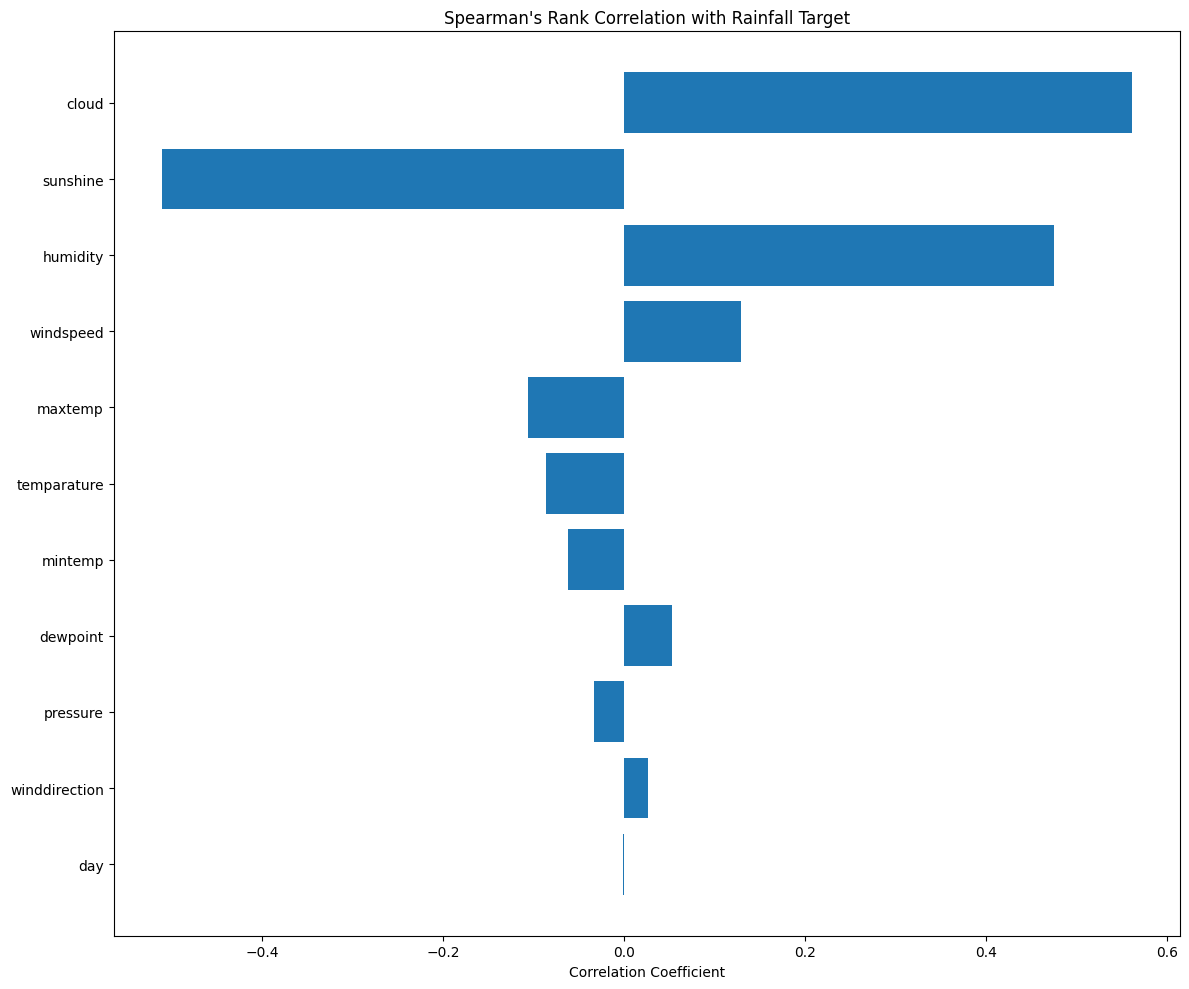

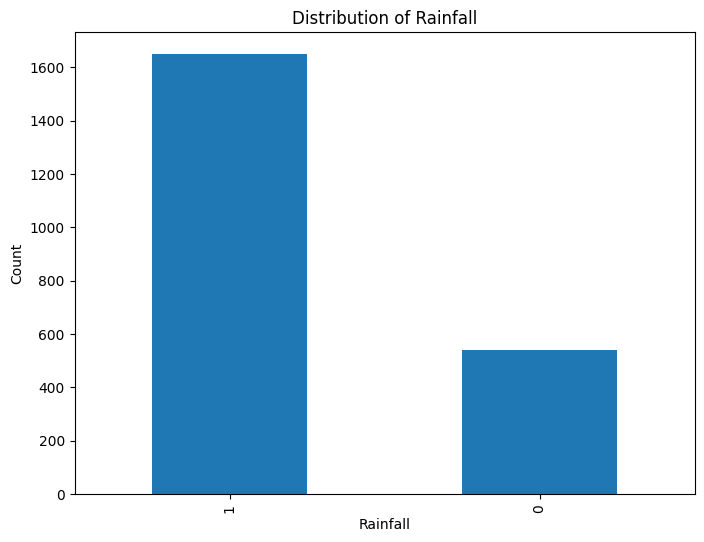

In [ ]:
# Check for missing values
print("\nMissing values in training data:")
print(train_data.isnull().sum())
print("\nMissing values in test data:")
print(test_data.isnull().sum())

# Calculate Spearman's Rank Correlation with rainfall target
correlations = []
features = train_data.drop(['id', 'rainfall'], axis=1).columns
for feature in features:
    correlation = train_data[feature].corr(train_data['rainfall'], method='spearman')
    correlations.append({'Feature': feature, 'Correlation': correlation})

# Create dataframe and sort by absolute correlation
correlations_df = pd.DataFrame(correlations)
correlations_df['Abs_Correlation'] = correlations_df['Correlation'].abs()
correlations_df = correlations_df.sort_values('Abs_Correlation', ascending=True)

# Plot Spearman's Rank correlations
plt.figure(figsize=(12, 10))
plt.barh(correlations_df['Feature'], correlations_df['Correlation'])
plt.title("Spearman's Rank Correlation with Rainfall Target")
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

# Distribution of target variable
plt.figure(figsize=(8, 6))
train_data['rainfall'].value_counts().plot(kind='bar')
plt.title('Distribution of Rainfall')
plt.xlabel('Rainfall')
plt.ylabel('Count')
plt.show()

#### Spearman's Rank Correlation Insights:
- The strong positive correlations of cloud and sunshine suggest that these meteorological factors are critical in predicting rainfall. This could guide feature selection for model training.
- The weak correlations of certain features (like "day" and "pressure") may indicate that they could be candidates for removal or require transformation to improve model performance.

#### Distribution of target variable Insights:
- The imbalance in the target variable indicates that the model may be biased towards predicting the majority class (rainfall = 1). Techniques such as resampling (oversampling the minority class or undersampling the majority class) or using different evaluation metrics (like F1-score, precision, and recall) may be necessary to ensure the model performs well across both classes.
- The imbalance in the target variable (many more non-rainy days than rainy days) indicates that the model may struggle to predict rare events accurately.


# 3. Data Preprocessing

In [7]:
train_data.columns

Index(['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed', 'rainfall'],
      dtype='object')

In [46]:
# Separate features and target

X = train_data.drop(['id', 'rainfall'], axis=1)
y = train_data['rainfall']
test_imputed = test_data.drop('id', axis=1)


# Split the data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# 5. Model Training and Evaluation

## 5.1 Random Forest

In [39]:
print("\nRandom Forest Classifier:")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_val_pred = rf_model.predict_proba(X_val)[:, 1]
rf_auc = roc_auc_score(y_val, rf_val_pred)
print(f"Validation AUC: {rf_auc:.4f}")


Random Forest Classifier:
Validation AUC: 0.8573


## 5.2 Gradient Boosting

In [37]:
print("\nGradient Boosting Classifier:")
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
gb_val_pred = gb_model.predict_proba(X_val)[:, 1]
gb_auc = roc_auc_score(y_val, gb_val_pred)
print(f"Validation AUC: {gb_auc:.4f}")


Gradient Boosting Classifier:
Validation AUC: 0.8629


## 5.3 XGBoost

In [38]:
print("\nXGBoost Classifier:")
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_val_pred = xgb_model.predict_proba(X_val)[:, 1]
xgb_auc = roc_auc_score(y_val, xgb_val_pred)
print(f"Validation AUC: {xgb_auc:.4f}")


XGBoost Classifier:
Validation AUC: 0.8554


# ROC curves comparison

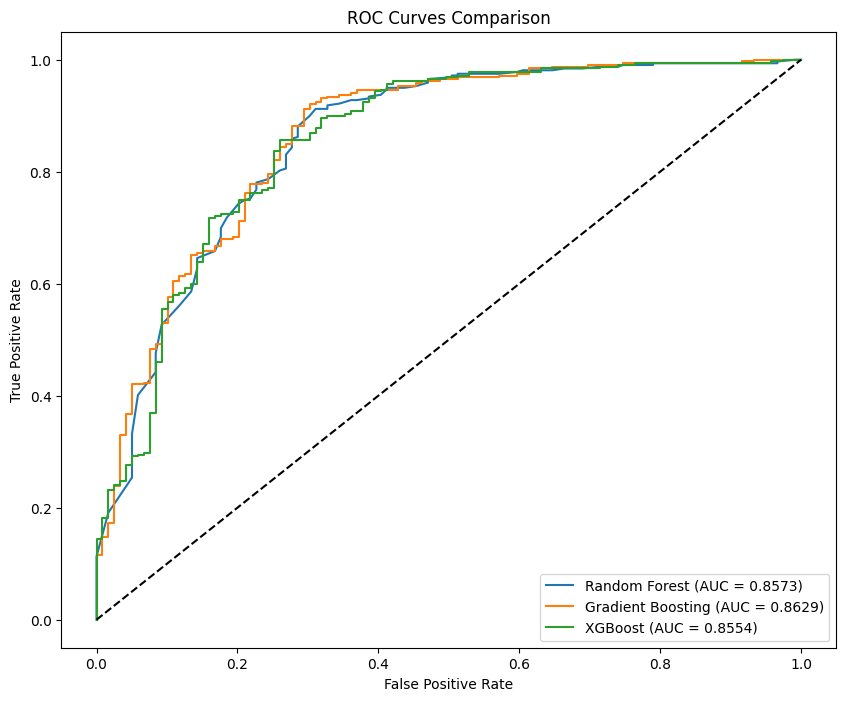

In [40]:
plt.figure(figsize=(10, 8))
# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_val, rf_val_pred)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.4f})')

# Gradient Boosting
fpr_gb, tpr_gb, _ = roc_curve(y_val, gb_val_pred)
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {gb_auc:.4f})')

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, xgb_val_pred)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()

# 6. Hyperparameter Tuning

## 6.1 XGBboost

In [41]:
# Use the best model from above (assuming XGBoost based on performance) and fine-tune it
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# You might want to uncomment this for more in-depth tuning, but it can be time-consuming
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X, y)
best_params = grid_search.best_params_
print("\nBest parameters:", best_params)

# For now, let's use a good set of parameters based on experience
# best_params = {
#     'n_estimators': 50,
#     'max_depth': 2,
#     'learning_rate': 0.1,
#     'subsample': 0.9,
#     'colsample_bytree':  0.8
# }


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


## 6.2 RandomForest

In [ ]:
# Use the best model from above (assuming XGBoost based on performance) and fine-tune it
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# You might want to uncomment this for more in-depth tuning, but it can be time-consuming
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X, y)
best_params = grid_search.best_params_
print("\nBest parameters:", best_params)

# For now, let's use a good set of parameters based on experience
# best_params = {
# 'bootstrap': True, 
# 'max_depth': 5,
# 'max_features': 'sqrt',
# 'min_samples_leaf': 2,
# 'min_samples_split': 2,
# 'n_estimators': 10}
# }


Best parameters: {'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}


# 6.3 Gradient Boosting 

In [42]:
# Use the best model from above (assuming XGBoost based on performance) and fine-tune it
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt', 'log2']
}

# You might want to uncomment this for more in-depth tuning, but it can be time-consuming
grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X, y)
best_params = grid_search.best_params_
print("\nBest parameters:", best_params)

# For now, let's use a good set of parameters based on experience
# best_params = {
#     'n_estimators': 50,
#     'max_depth': 2,
#     'learning_rate': 0.1,
#     'subsample': 0.9,
#     'colsample_bytree':  0.8
# }


Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50, 'subsample': 0.9}


# 7. Final Model Training

In [43]:
final_model = GradientBoostingClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    subsample=best_params['subsample'],
    max_features=best_params['max_features'],
    random_state=42
)

# Train on the full dataset
final_model.fit(X, y)

GradientBoostingClassifier(max_features='sqrt', min_samples_split=10,
                           n_estimators=50, random_state=42, subsample=0.9)

In [28]:
final_model = RandomForestClassifier(
    bootstrap=best_params['bootstrap'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    n_estimators=best_params['n_estimators'],
    random_state=42
)

# Train on the full dataset
final_model.fit(X, y)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, n_estimators=10,
                       random_state=42)

In [33]:
final_model = xgb.XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42
)

# Train on the full dataset
final_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

# 8. Make predictions on the test set

In [49]:
test_pred_proba = final_model.predict_proba(test_imputed.fillna(0))[:, 1]


# 9. Create submission file


Submission file created successfully!


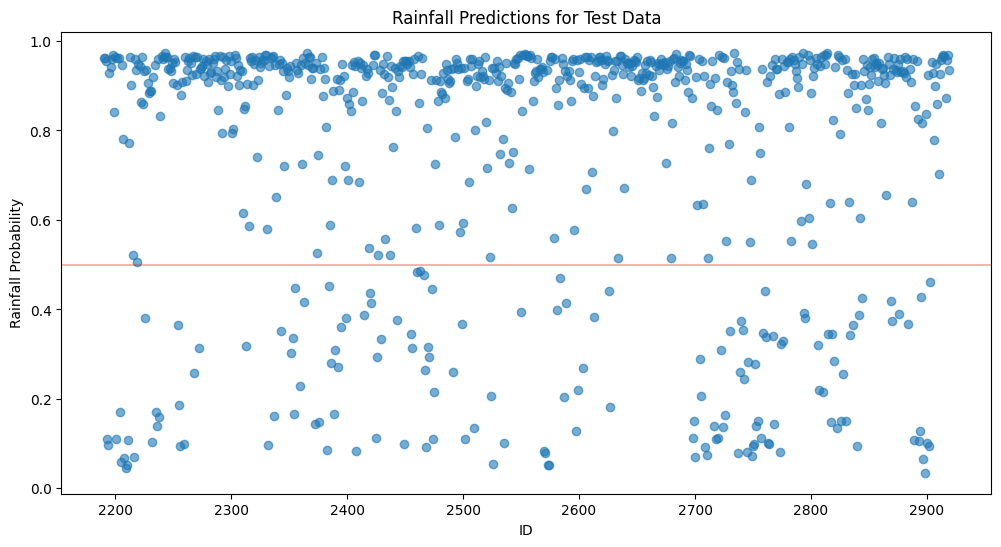

In [50]:
submission['rainfall'] = test_pred_proba
submission.to_csv('rainfall_prediction_submission_gboost.csv', index=False)

print("\nSubmission file created successfully!")

# Visualize a few predictions
plt.figure(figsize=(12, 6))
plt.scatter(test_data['id'], test_pred_proba, alpha=0.6)
plt.axhline(y=0.5, color='r', linestyle='-', alpha=0.3)
plt.title('Rainfall Predictions for Test Data')
plt.xlabel('ID')
plt.ylabel('Rainfall Probability')
plt.show()

# 10. Feature Importance of Final Model

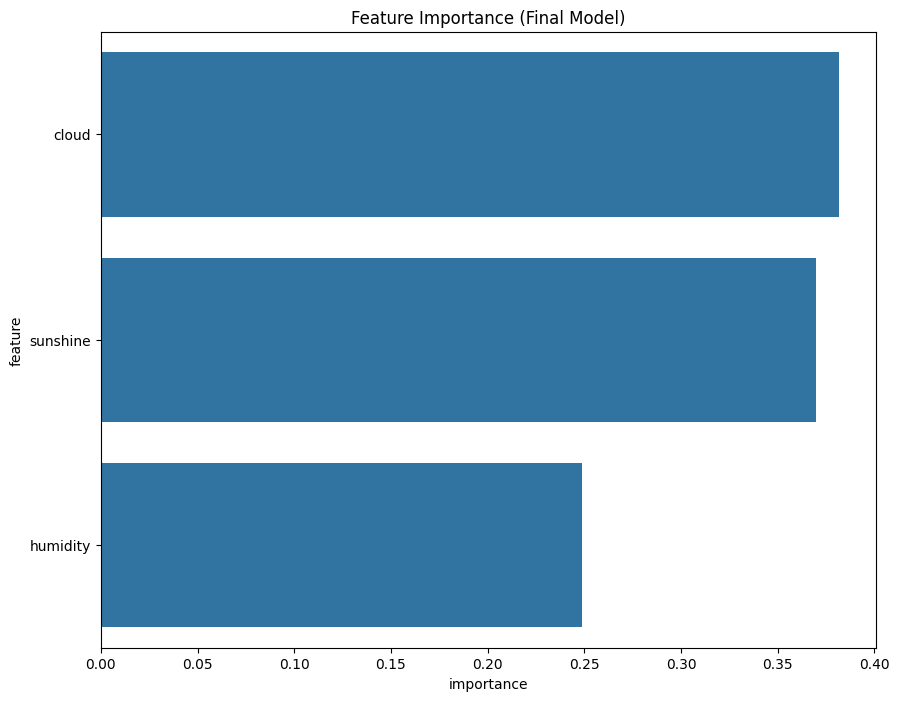

In [31]:
feature_importance_final = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_final)
plt.title('Feature Importance (Final Model)')
plt.show()

# 11. Additional Analysis

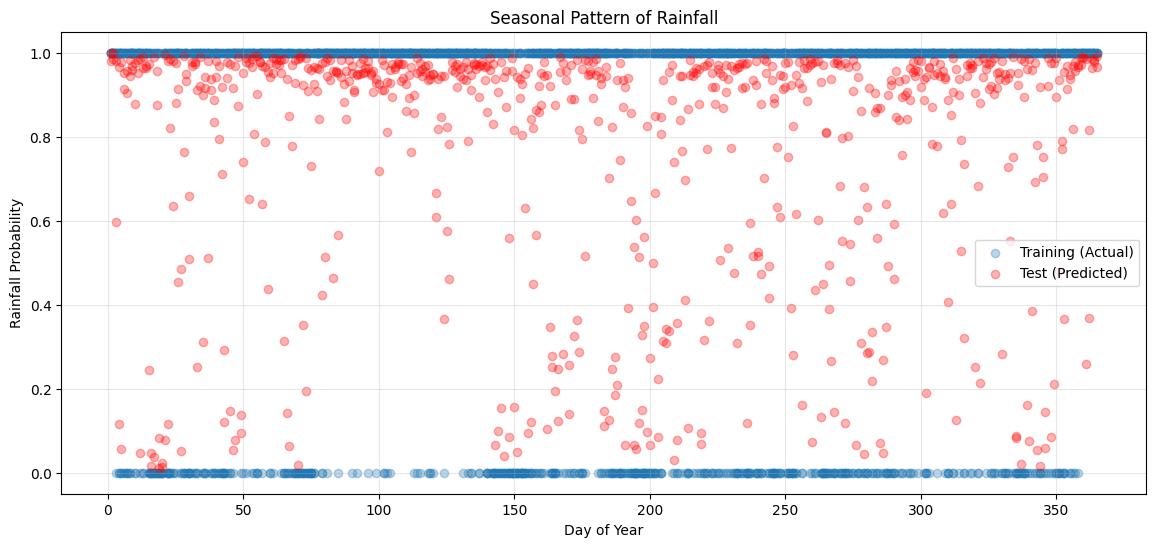

ValueError: Could not interpret value `rolling_avg_temp_3` for `y`. An entry with this name does not appear in `data`.

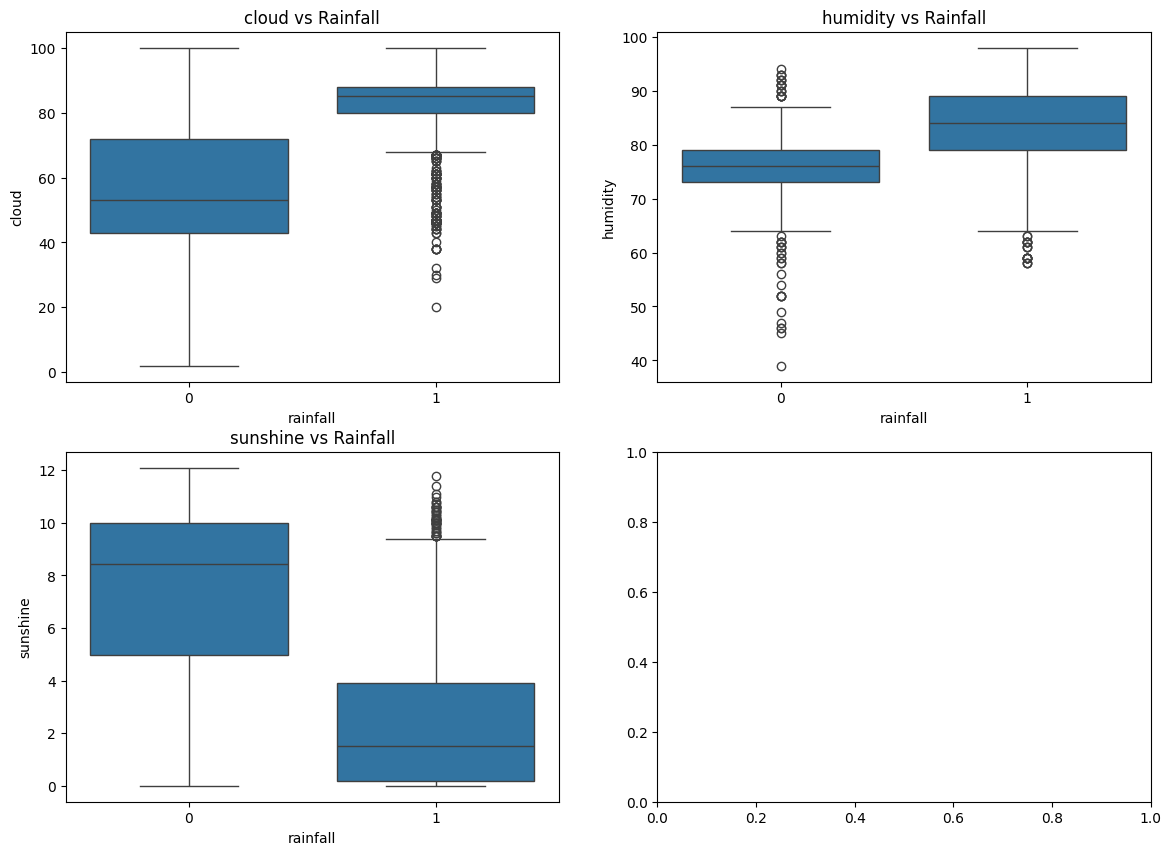

In [74]:
# Seasonal patterns
train_data['prediction'] = 0  # Just for visualization
test_prediction_df = pd.DataFrame({
    'day': test_data['day'],
    'prediction': test_pred_proba
})

# Combine for visualization
plt.figure(figsize=(14, 6))
plt.scatter(train_data['day'], train_data['rainfall'], alpha=0.3, label='Training (Actual)')
plt.scatter(test_data['day'], test_pred_proba, alpha=0.3, label='Test (Predicted)', color='red')
plt.title('Seasonal Pattern of Rainfall')
plt.xlabel('Day of Year')
plt.ylabel('Rainfall Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Relationship between important features and rainfall
top_features = feature_importance_final.head(4)['feature'].values

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    sns.boxplot(x='rainfall', y=feature, data=train_data, ax=axes[i])
    axes[i].set_title(f'{feature} vs Rainfall')
    
plt.tight_layout()
plt.show()

print("Analysis complete!")